# What physio-chemical properties make wine 'good'?

Data from kaggle: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

Purpose of project is to determine what physio-chemical properties make wine good using linear regression. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import and check data

In [2]:
wine_df = pd.read_csv('winequality-red.csv')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


11 columns, no null values, and all values are numeric. Data probably clean - check for duplicates and outliers.

In [4]:
#Remove duplicates
print("Shape before: ",wine_df.shape)
wine_df.drop_duplicates(inplace = True)
print("Shape after: ", wine_df.shape)

Shape before:  (1599, 12)
Shape after:  (1359, 12)


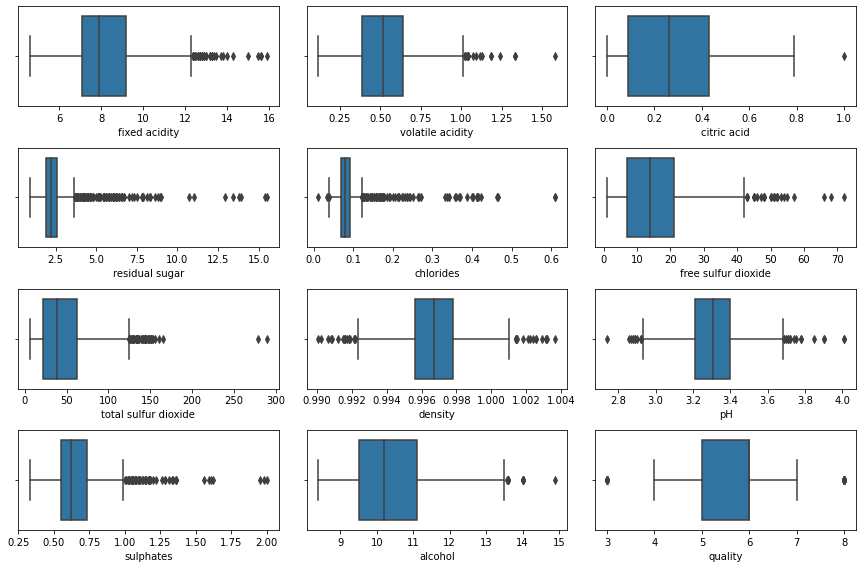

In [5]:
#Check for extreme outliers
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (12, 8))
for i, col in enumerate(wine_df.columns):
    sns.boxplot(x = wine_df[col], ax = axes[i//3, i%3])
plt.tight_layout()

There are no very extreme outliers and everything is within a sensible range so can carry on with analysis

# Data Visualisation

In [6]:
sns.set_style('whitegrid')

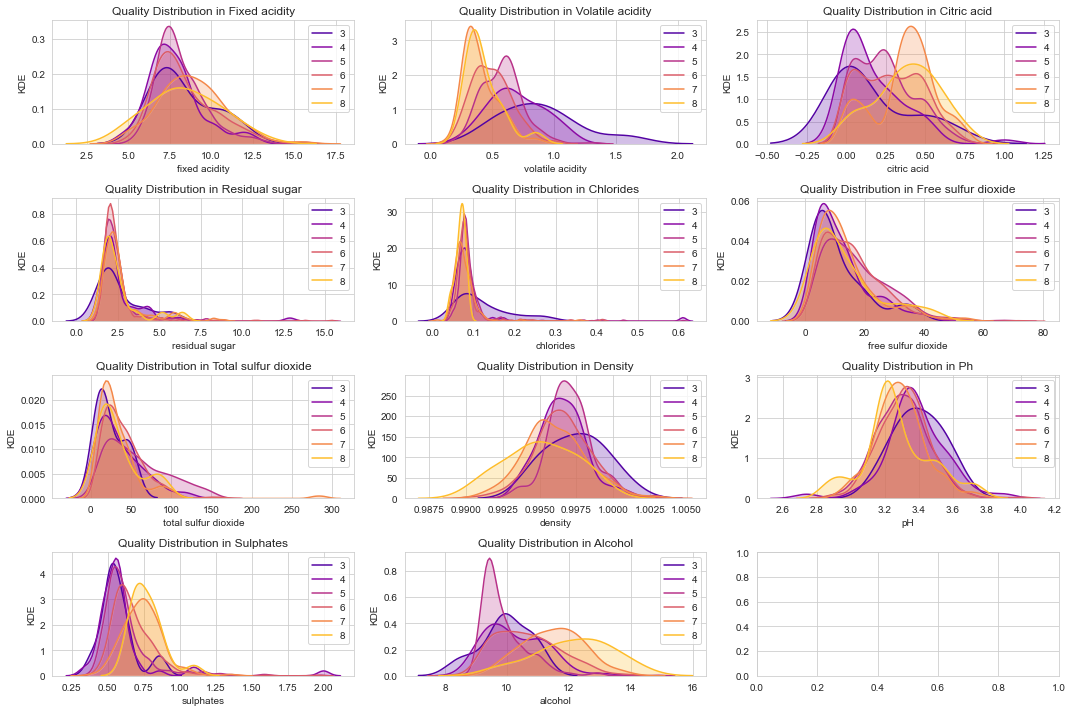

In [7]:
#Visualising distribution of wine quality within each feature
sns.set_palette('plasma')
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15,10))
wine_qual = wine_df.groupby('quality').mean()
for i, col in enumerate(wine_qual.columns):
    gr = wine_df.groupby('quality')[col]
    for label, arr in gr:
        plot = sns.kdeplot(arr, label=label, shade=True, ax = axes[i//3, i%3])
        plot.set_xlabel(col)
        plot.set_ylabel("KDE")
        plot.set_title("Quality Distribution in {}".format(col.capitalize()))
plt.tight_layout()



* For some features there is a large overlap of wine quality - for example the KDE peaks for each quality are approximately the same for fixed acidity, residual sugar, chlorides, free sulfur dioxide and total sulfur dioxide. 
* Some features show clear trends - volatile acidity and alcohol for example.
* For some features the trends are less pronounced - pH, sulphates, density and citric acid
Because quality is discrete visualising the trends with scatter/lmplots is not easy so instead we can group the values by quality and plot the mean value. 

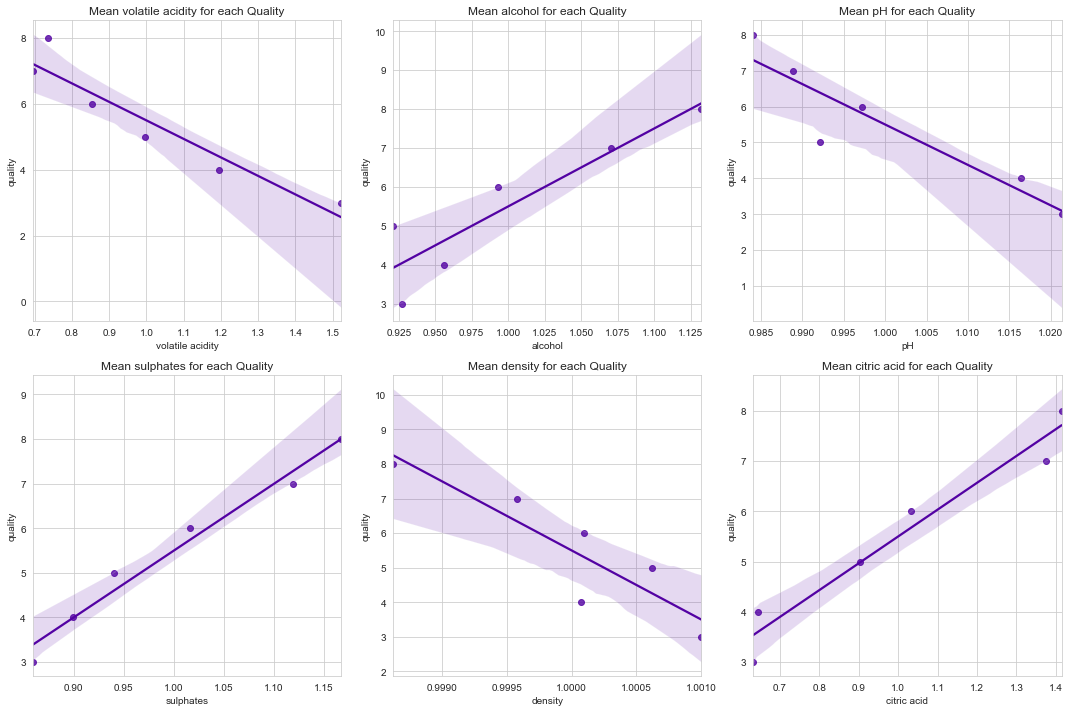

In [8]:
wine_qual_norm = wine_qual
for col in wine_qual.columns:
    wine_qual_norm[col] = wine_qual[col].apply(lambda x: x/wine_qual[col].mean()) 
wine_qual
features_of_interest = ['volatile acidity', 'alcohol', 'pH', 'sulphates', 'density', 'citric acid']
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))
for i, feat in enumerate(features_of_interest):
    plot = sns.regplot(data = wine_qual_norm.reset_index(), x = feat, y = 'quality', ax = axes[i//3, i%3])
    plot.set_title("Mean {} for each Quality".format(feat))
plt.tight_layout()

We can also check which features have the most correlation with quality

In [9]:
print(wine_df.corr()['quality'].abs().sort_values(ascending = False))

quality                 1.000000
alcohol                 0.480343
volatile acidity        0.395214
sulphates               0.248835
citric acid             0.228057
density                 0.184252
total sulfur dioxide    0.177855
chlorides               0.130988
fixed acidity           0.119024
pH                      0.055245
free sulfur dioxide     0.050463
residual sugar          0.013640
Name: quality, dtype: float64


So from this we expect the alcohol content to have the largest effect in the linear regression.

# Linear Regression

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
X = wine_df.drop('quality', axis = 1)
y = wine_df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(X_train)

MinMaxScaler()

In [20]:
X_train = scaler.transform(X_train)

In [21]:
X_test = scaler.transform(X_test)

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
linreg = LinearRegression()

In [24]:
linreg.fit(X_train, y_train)

LinearRegression()

Text(0, 0.5, 'Counts')

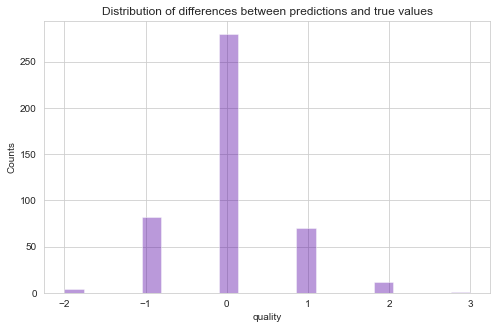

In [25]:
#Predictions from model, rounded to the nearest integer
pred = linreg.predict(X_test)
pred_int = pred.round()
differences = pred_int - y_test
plt.figure(figsize = (8,5))
sns.distplot(differences, kde = False)
plt.title("Distribution of differences between predictions and true values")
plt.ylabel('Counts')

In [26]:
#Finding percentage of correct, within one point and over one point predictions
percent = differences.value_counts()/len(differences)*100
print("Correct predictions: {:.4}%".format(percent[0]))
print("Within one point: {:.4}%".format(percent[1]+percent[-1]))
print("Over one point out: {:.4}%".format(100 - percent[[0,1,-1]].sum()))

Correct predictions: 62.36%
Within one point: 33.85%
Over one point out: 3.786%


So overall the model is not bad - with around 95% of predictions within one point of the true value. 

In [27]:
coeffs = pd.DataFrame(linreg.coef_, X.columns, columns = ['Coefficients'] )

In [56]:
coeffs.sort_values(by = 'Coefficients', ascending = False, inplace = True)

In [57]:
coeffs

,Coefficients
alcohol,1.944890
sulphates,1.490097
free sulfur dioxide,0.390394
density,0.175256
residual sugar,0.076097
citric acid,-0.023776
fixed acidity,-0.329729
pH,-0.912204
total sulfur dioxide,-1.022486
chlorides,-1.212766


# What physio-chemical attributes affect the quality of wine?

From the results it seems that the alcohol content has the greatest effect on predicting the quality of wine. Alcohol affects the taste, aroma and texture of wine and so it is unsurprising that alcohol content has such a large contribution to the quality. Alcohol can enhance subtle and complex aromas, create the 'illusion of sweetness' and contributes to a syrupy mouth feel.(1)  

The next two factors which have a large effect on quality are the volatile acidity, which is negatively correlated, and the sulphate content, which is positively correlated. These two factors are actually intrinisically linked, which perhaps explains why the absolute values of their coefficients are so close. Volatile acidity is caused by bacteria in wine producing acetic acid (vinegar), and suphate content prevents this bacteria from growing. The respective correlations these factors have with quality makes sense because although tastes vary from person to person most agree that 'vinegary' wine is unpleasant. (2-3)

Finally the next most important factor is chloride content, which is negatively correlated with wine quality. Chloride content is associated with a salty taste and so again this correlation makes sense.(4)

To conclude; people seem to like high alcohol wine that does not taste of vinegar or salt. 


References:  

(1) http://jackyblisson.com/alcohol-in-wine/  

(2) https://winemakermag.com/article/676-the-perils-of-volatile-acidity#:~:text=Volatile%20acidity%20is%20mostly%20caused%20by%20bacteria%20in,rogue%20yeasts%20that%20can%20do%20the%20same%20thing.  

(3) http://www.winenous.co.uk/wp/archives/12752  

(4) Walker et al,  http://dx.doi.org/10.1111/j.1755-0238.2009.00081.x
